In [ ]:
import math
import numpy as np
from tqdm.notebook import tqdm
# tqdm = lambda x: x

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torchvision import datasets, transforms

from google.colab import files
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('legend', title_fontsize=16)
plt.rc('legend', framealpha=0.0)
plt.rc('figure', titlesize=16)
plt.rc('lines', linewidth=3)
plt.rc('figure', figsize = [6.5, 4])

## Get the MNIST data

In [ ]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, download=True, transform=transform)

def get_data(num_train_examples, num_test_examples, random_labels, binary_digits):

    if binary_digits:
        train_superset = []
        for data in trainset:
            if data[1] < 2:
                train_superset.append( data )
        test_superset = []
        for data in testset:
            if data[1] < 2:
                test_superset.append( data )
    else:
        train_superset = trainset
        test_superset = testset

    indices = np.random.permutation(len(train_superset))[0:num_train_examples]
    train_subset = torch.utils.data.Subset(train_superset, indices)

    indices = np.random.permutation(len(test_superset))[0:num_test_examples]
    test_subset = torch.utils.data.Subset(test_superset, indices)

    if random_labels:
        random_train_subset = []
        for data in train_subset:
            random_train_subset.append( ( data[0], torch.randint(low=0,high=2,size=(1,)).item() ) )
        train_subset = random_train_subset

        random_test_subset = []
        for data in test_subset:
            random_test_subset.append( ( data[0], torch.randint(low=0,high=2,size=(1,)).item() ) )
        test_subset = random_test_subset

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

    return train_loader, test_loader

def normalize_data(data, target):
    data = data.view(data.shape[0],-1)
    data /= data.norm(dim=1).unsqueeze(dim=1)
    data *= math.sqrt(data.shape[1])
    target = target%2*2-1
    return data, target.float()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Nero optimiser

In [ ]:
def neuron_norm(x):
    if x.dim() > 1:
        view_shape = [x.shape[0]] + [1]*(x.dim()-1)
        x = x.view(x.shape[0],-1)
        return x.norm(dim=1).view(*view_shape)
    else:
        return x.abs()

def neuron_mean(x):
    if x.dim() > 1:
        view_shape = [x.shape[0]] + [1]*(x.dim()-1)
        x = x.view(x.shape[0],-1)
        return x.mean(dim=1).view(*view_shape)
    else:
        raise Exception("neuron_mean not defined on 1D tensors.")

class Nero(Optimizer):

    def __init__(self, params, lr=0.01, beta=0.999, constraints=True):
        self.beta = beta
        self.constraints = constraints
        defaults = dict(lr=lr)
        super(Nero, self).__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                if self.constraints and p.dim() > 1:
                    p.data -= neuron_mean(p)
                    p.data /= neuron_norm(p)
                state = self.state[p]
                state['step'] = 0
                state['exp_avg_sq'] = torch.zeros_like(neuron_norm(p))
                state['scale'] = neuron_norm(p).mean()
                if state['scale'] == 0.0:
                    state['scale'] = 0.01

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]

                state['step'] += 1
                bias_correction = 1 - self.beta ** state['step']
                state['exp_avg_sq'] = self.beta * state['exp_avg_sq'] + (1-self.beta) * neuron_norm(p.grad)**2

                grad_normed = p.grad / (state['exp_avg_sq']/bias_correction).sqrt()
                grad_normed[torch.isnan(grad_normed)] = 0
                
                p.data -= group['lr'] * state['scale'] * grad_normed

                if self.constraints and p.dim() > 1:
                    p.data -= neuron_mean(p)
                    p.data /= neuron_norm(p)

        return loss

## Create network trainer

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, depth, width):
        super(SimpleNet, self).__init__()

        self.initial = nn.Linear(784, width, bias=False)
        self.layers = nn.ModuleList([nn.Linear(width, width, bias=False) for _ in range(depth-2)])
        self.final = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        x = self.initial(x)
        x = F.relu(x) * math.sqrt(2)
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x) * math.sqrt(2)
        return self.final(x)


def train_network(train_loader, test_loader, depth, width, init_lr, decay, target_scale, gauss_target):
    
    model = SimpleNet(depth, width).cuda()
    optim = Nero(model.parameters(), lr=init_lr)
    lr_lambda = lambda x: decay**x
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

    data, target = next(iter(train_loader))
    data, target = (data.cuda(), target.cuda())
    data, target = normalize_data(data, target)

    if gauss_target:
        target *= torch.randn_like(target).abs()

    train_acc_list = []
    train_acc = 0

    model.train()

    for epoch in range(500):

        y_pred = model(data).squeeze()
        loss = (y_pred - target_scale*target).norm()

        model.zero_grad()
        loss.backward()
        optim.step()

        correct = (target.sign() == y_pred.sign()).sum().item()
        total = target.shape[0]
        train_acc_list.append(correct/total)

        lr_scheduler.step()

    # print( "final training RMS error:", loss.item()/math.sqrt(total) )

    model.eval()
    
    data, target = next(iter(test_loader))
    data, target = (data.cuda(), target.cuda())
    data, target = normalize_data(data, target)
        
    y_pred = model(data).squeeze()
    correct = (target == y_pred.sign()).sum().item()
    total = target.shape[0]

    test_acc = correct/total

    return train_acc_list, test_acc, y_pred.detach()

## Implement the Gibbs bound

In [ ]:
def sanitise(sigma):
    return sigma.clamp(min=-1,max=1)

def increment_kernel(sigma):
    new_sigma = (1-sigma**2).sqrt()
    new_sigma += sigma*(math.pi - sigma.acos())
    new_sigma /= math.pi
    return sanitise(new_sigma)

# TODO: rewrite with cholesky_solve and Frobenius norm trace
def gibbs_bound(sigma, c):
    n = sigma.shape[0]
    device = sigma.device
    id = torch.eye(n, device=device)

    assert ( sigma == sigma.t() ).all()
    u = torch.cholesky(sigma)
    inv = torch.cholesky_inverse(u)
    assert (torch.mm(sigma, inv) - id).abs().max() < 1e-03

    nth_root_det = u.diag().pow(2/n).prod()
    inv_trace = inv.diag().sum()
    inv_proj = torch.dot(c, torch.mv(inv, c))

    complexity = n*(math.log(2)-0.5) + nth_root_det * ( (0.5 - 1/math.pi)*inv_trace + inv_proj/math.pi )

    return complexity

def invert_bound(x):
    return 1-math.exp(-x)

## Train everything

In [ ]:
print("\nGetting data...")

### Dependent variables
num_test_examples = 10000
random_labels = False
binary_digits = False
depth = 7
width = 1000
num_train_examples_list = np.arange(start=50, stop=1050, step=50)

### Finite width NN hyperparameters
init_lr = 0.01
decay = 0.99

### Ensemble hyperparameters
num_gp_voters = 10**5
num_nn_voters = 501

### Bound parameters
delta = 0.01

### Set random seed
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

gp_gibbs_bound_list = []
rademacher_bound_list = []

gp_gibbs_list = []
gp_bayes_list = []
kernel_list = []

nn_gibbs_list = []
nn_bayes_list = []
large_margin_nn_list = []

for num_train_examples in num_train_examples_list:
    print(num_train_examples, "********************")

    data = get_data( num_train_examples=num_train_examples,
                    num_test_examples=num_test_examples,
                    random_labels=random_labels, 
                    binary_digits=binary_digits )

    train_loader, test_loader = data

    print("\nCompute kernel")

    train_data, train_target = list(train_loader)[0]
    test_data, test_target = list(test_loader)[0]

    data = torch.cat((train_data, test_data), dim=0)
    target = torch.cat((train_target, test_target), dim=0)

    data, target = data.cuda(), target.cuda()
    data, target = normalize_data(data, target)

    sigma = sanitise(torch.mm(data, data.t()) / data.shape[1]).cpu()
    assert ( sigma == sigma.t() ).all()

    for _ in range(depth-1):
        sigma = increment_kernel(sigma)
        assert ( sigma == sigma.t() ).all()

    sigma_bb = sigma[:num_train_examples, :num_train_examples]
    sigma_ab = sigma[num_train_examples:, :num_train_examples]
    sigma_ba = sigma[:num_train_examples, num_train_examples:]
    sigma_aa = sigma[num_train_examples:, num_train_examples:]

    x_b = target[:num_train_examples].float().cpu()
    x_a = target[num_train_examples:].float().cpu()

    sigma_bb_inv = torch.cholesky_inverse(torch.cholesky(sigma_bb))
    logdet = torch.logdet(sigma_bb);
    nth_root_det = torch.exp(logdet/num_train_examples)

    print("\nComputing bounds")

    formula = gibbs_bound(sigma_bb, x_b)
    uninverted_bound = ( formula + math.log(2*num_train_examples/delta) ) / (num_train_examples-1)
    gp_gibbs_bound = invert_bound(uninverted_bound)
    gp_gibbs_bound_list.append(gp_gibbs_bound*100)

    rademacher_bound = 4 * (x_b @ sigma_bb_inv @ x_b).sqrt() / math.sqrt(num_train_examples)
    rademacher_bound_list.append(rademacher_bound*100)

    print("\nTraining large margin finite width NN")

    target_scale = 100.0
    nn_train_acc, nn_test_acc, _ = train_network(train_loader, test_loader, depth, width, init_lr, decay, target_scale=target_scale, gauss_target=False)
    print("Target scale:", target_scale)
    print(nn_train_acc)
    large_margin_nn_error = 1-nn_test_acc

    print("\nTraining small margin finite width NNs")

    target_scale = nth_root_det.sqrt()
    print("Target scale:", target_scale)

    voter_error_list = []
    running_vote = None
    for voter in tqdm(range(num_nn_voters)):
        nn_train_acc, nn_test_acc, pred = train_network(train_loader, test_loader, depth, width, init_lr, decay, target_scale=target_scale, gauss_target=True)
        voter_error_list.append(1-nn_test_acc)
        if running_vote is None:
            running_vote = pred.sign()
        else:
            running_vote += pred.sign()
    nn_gibbs_error = np.mean(voter_error_list)
    nn_bayes_error = 1 - (x_a == running_vote.sign().cpu()).sum() / num_test_examples

    print("\nCompute the Bayes accuracy")

    labels = ( torch.randn(num_gp_voters, num_train_examples).abs() * nth_root_det.sqrt() * x_b ).t()
    cond_mu = sigma_ab @ sigma_bb_inv @ labels
    cond_sigma = torch.diag(sigma_aa - sigma_ab @ sigma_bb_inv @ sigma_ba).sqrt()

    pred_noise = ( torch.randn(num_gp_voters, num_test_examples) * cond_sigma ).t()
    pred = ( cond_mu + pred_noise ).sign()
    
    vote = pred.sum(dim=1).sign()
    ensemble_acc = (x_a == pred.t()).sum(dim=1) / num_test_examples

    gp_bayes_error = 1 - (x_a == vote).sum() / num_test_examples
    gp_gibbs_error = 1 - ensemble_acc.mean()

    kernel_pred = (sigma_ab @ sigma_bb_inv @ x_b).sign()
    kernel_error = 1 - (kernel_pred == x_a).sum() / num_test_examples

    print("GP Gibbs bound:", gp_gibbs_bound*100)
    print("Rademacher bound:", rademacher_bound*100)
    print("GP Gibbs:", gp_gibbs_error*100)
    print("GP Bayes:", gp_bayes_error*100)
    print("kernel:", kernel_error*100)
    print("NN Gibbs:", nn_gibbs_error*100)
    print("NN Bayes:", nn_bayes_error*100)
    print("large margin NN:", large_margin_nn_error*100)

    gp_gibbs_list.append(gp_gibbs_error*100)
    gp_bayes_list.append(gp_bayes_error*100)
    kernel_list.append(kernel_error*100)
    nn_gibbs_list.append(nn_gibbs_error*100)
    nn_bayes_list.append(nn_bayes_error*100)
    large_margin_nn_list.append(large_margin_nn_error*100)


Getting data...
50 ********************

Compute kernel


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)



Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.4, 1.0, 1.0, 0.96, 0.98, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 58.47015638896593
Rademacher bound: tensor(840.4398)
GP Gibbs: tensor(39.0524)
GP Bayes: tensor(20.6500)
kernel: tensor(20.6600)
NN Gibbs: 37.24644710578843
NN Bayes: tensor(24.4100)
large margin NN: 21.140000000000004
100 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.38, 0.99, 0.97, 0.98, 0.92, 0.46, 0.96, 1.0, 1.0, 0.92, 0.92, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 51.429639310152076
Rademacher bound: tensor(783.2839)
GP Gibbs: tensor(34.2134)
GP Bayes: tensor(12.8700)
kernel: tensor(12.8900)
NN Gibbs: 32.57441117764471
NN Bayes: tensor(13.1900)
large margin NN: 12.629999999999997
150 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.4866666666666667, 1.0, 0.9866666666666667, 0.98, 0.94, 0.5, 0.9333333333333333, 1.0, 1.0, 0.8466666666666667, 0.9733333333333334, 1.0, 0.9733333333333334, 0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 48.65249582297812
Rademacher bound: tensor(758.3615)
GP Gibbs: tensor(32.3396)
GP Bayes: tensor(11.1200)
kernel: tensor(11.1700)
NN Gibbs: 31.11273453093813
NN Bayes: tensor(10.0000)
large margin NN: 10.19
200 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.505, 0.94, 0.935, 0.89, 0.835, 0.57, 0.915, 0.94, 0.945, 0.965, 0.96, 0.775, 0.91, 0.995, 0.99, 0.995, 0.96, 0.91, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 47.27281226304163
Rademacher bound: tensor(748.7816)
GP Gibbs: tensor(30.8490)
GP Bayes: tensor(9.9600)
kernel: tensor(9.9600)
NN Gibbs: 30.608343313373254
NN Bayes: tensor(10.4400)
large margin NN: 9.140000000000004
250 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.48, 0.98, 0.944, 0.924, 0.908, 0.512, 0.948, 0.972, 0.98, 0.98, 0.988, 0.756, 0.888, 0.988, 0.996, 0.996, 1.0, 0.984, 0.9, 0.956, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 44.91825339770561
Rademacher bound: tensor(677.8162)
GP Gibbs: tensor(30.7165)
GP Bayes: tensor(8.8900)
kernel: tensor(8.8600)
NN Gibbs: 29.267385229540917
NN Bayes: tensor(10.5100)
large margin NN: 8.850000000000001
300 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.5366666666666666, 0.97, 0.9233333333333333, 0.8866666666666667, 0.9133333333333333, 0.84, 0.7833333333333333, 0.7233333333333334, 0.9566666666666667, 0.9666666666666667, 0.97, 0.8166666666666667, 0.85, 0.9866666666666667, 0.9866666666666667, 0.99, 0.9833333333333333, 0.9033333333333333, 0.9933333333333333, 0.9933333333333333, 0.9966666666666667, 0.9933333333333333, 0.9933333333333333, 0.9666666666666667, 0.9933333333333333, 0.9966666666666667, 0.9966666666666667, 1.0, 0.9966666666666667, 0.9966666666666667, 1.0, 0.9966666666666667, 0.9966666666666667, 1.0, 0.9966666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 45.45941774811644
Rademacher bound: tensor(739.1733)
GP Gibbs: tensor(30.5407)
GP Bayes: tensor(9.6200)
kernel: tensor(9.6400)
NN Gibbs: 29.255489021956087
NN Bayes: tensor(9.7600)
large margin NN: 9.319999999999995
350 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.49714285714285716, 0.9571428571428572, 0.9228571428571428, 0.8914285714285715, 0.88, 0.6028571428571429, 0.9514285714285714, 0.9514285714285714, 0.9628571428571429, 0.9714285714285714, 0.6142857142857143, 0.9828571428571429, 0.9857142857142858, 0.9771428571428571, 0.9571428571428572, 0.7628571428571429, 0.9828571428571429, 0.9914285714285714, 0.9971428571428571, 1.0, 0.9971428571428571, 0.9114285714285715, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 43.89927927178292
Rademacher bound: tensor(686.8297)
GP Gibbs: tensor(29.4625)
GP Bayes: tensor(8.1000)
kernel: tensor(8.1200)
NN Gibbs: 28.100079840319363
NN Bayes: tensor(9.4300)
large margin NN: 7.8400000000000025
400 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.4825, 0.9325, 0.9225, 0.905, 0.875, 0.6175, 0.9525, 0.94, 0.95, 0.96, 0.825, 0.6825, 0.9775, 0.9775, 0.98, 0.9825, 0.9925, 0.98, 0.955, 0.9675, 0.97, 0.9775, 0.975, 0.995, 1.0, 0.9975, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 43.062535055054
Rademacher bound: tensor(668.2844)
GP Gibbs: tensor(29.6503)
GP Bayes: tensor(8.5400)
kernel: tensor(8.5300)
NN Gibbs: 27.504191616766466
NN Bayes: tensor(9.4900)
large margin NN: 8.450000000000003
450 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.39555555555555555, 0.9377777777777778, 0.9111111111111111, 0.8733333333333333, 0.8022222222222222, 0.6177777777777778, 0.92, 0.9288888888888889, 0.9311111111111111, 0.9333333333333333, 0.9422222222222222, 0.9511111111111111, 0.8244444444444444, 0.8, 0.9488888888888889, 0.9733333333333334, 0.9755555555555555, 0.9733333333333334, 0.9044444444444445, 0.8155555555555556, 0.9888888888888889, 0.9866666666666667, 0.9911111111111112, 0.9955555555555555, 1.0, 0.9977777777777778, 1.0, 0.9977777777777778, 0.8933333333333333, 0.94, 0.9955555555555555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 43.149897426094405
Rademacher bound: tensor(688.2380)
GP Gibbs: tensor(28.6412)
GP Bayes: tensor(6.5500)
kernel: tensor(6.5600)
NN Gibbs: 26.66139720558882
NN Bayes: tensor(7.0100)
large margin NN: 5.769999999999998
500 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.502, 0.916, 0.876, 0.882, 0.908, 0.944, 0.938, 0.604, 0.956, 0.97, 0.962, 0.73, 0.98, 0.98, 0.98, 0.972, 0.804, 0.822, 0.988, 0.988, 0.99, 0.992, 0.992, 1.0, 1.0, 1.0, 1.0, 0.98, 0.946, 0.876, 0.996, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 42.73986736046347
Rademacher bound: tensor(671.7559)
GP Gibbs: tensor(28.3961)
GP Bayes: tensor(5.9400)
kernel: tensor(5.9700)
NN Gibbs: 26.087025948103793
NN Bayes: tensor(7.0400)
large margin NN: 6.530000000000003
550 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.5, 0.9309090909090909, 0.9090909090909091, 0.8836363636363637, 0.7818181818181819, 0.6418181818181818, 0.9309090909090909, 0.9309090909090909, 0.9309090909090909, 0.94, 0.9472727272727273, 0.96, 0.9381818181818182, 0.8, 0.8636363636363636, 0.9672727272727273, 0.9654545454545455, 0.9618181818181818, 0.9054545454545454, 0.8781818181818182, 0.9763636363636363, 0.9745454545454545, 0.9836363636363636, 0.9836363636363636, 0.9927272727272727, 0.9872727272727273, 0.9963636363636363, 0.990909090909091, 0.9545454545454546, 0.8018181818181818, 0.9963636363636363, 0.9963636363636363, 0.9945454545454545, 0.9963636363636363, 

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 42.41424184908242
Rademacher bound: tensor(665.8848)
GP Gibbs: tensor(27.6898)
GP Bayes: tensor(5.7900)
kernel: tensor(5.7700)
NN Gibbs: 25.519820359281436
NN Bayes: tensor(7.0700)
large margin NN: 6.210000000000004
600 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.455, 0.9233333333333333, 0.895, 0.87, 0.775, 0.6966666666666667, 0.8866666666666667, 0.9016666666666666, 0.9066666666666666, 0.9183333333333333, 0.93, 0.9533333333333334, 0.9016666666666666, 0.6333333333333333, 0.9683333333333334, 0.9716666666666667, 0.9666666666666667, 0.975, 0.9883333333333333, 0.9466666666666667, 0.7466666666666667, 0.9866666666666667, 0.985, 0.9933333333333333, 0.995, 0.9733333333333334, 0.8583333333333333, 0.97, 0.9966666666666667, 0.9966666666666667, 1.0, 0.9983333333333333, 0.9966666666666667, 0.9916666666666667, 0.955, 0.985, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 42.23676895317987
Rademacher bound: tensor(671.3642)
GP Gibbs: tensor(27.5806)
GP Bayes: tensor(5.4300)
kernel: tensor(5.4300)
NN Gibbs: 25.435948103792416
NN Bayes: tensor(6.4100)
large margin NN: 5.610000000000004
650 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.4676923076923077, 0.9261538461538461, 0.9107692307692308, 0.8953846153846153, 0.8846153846153846, 0.5538461538461539, 0.9323076923076923, 0.94, 0.9415384615384615, 0.94, 0.6446153846153846, 0.9615384615384616, 0.9615384615384616, 0.9646153846153847, 0.963076923076923, 0.88, 0.7292307692307692, 0.9523076923076923, 0.9753846153846154, 0.9753846153846154, 0.9769230769230769, 0.9846153846153847, 0.9784615384615385, 0.8430769230769231, 0.9784615384615385, 0.9861538461538462, 0.9861538461538462, 0.943076923076923, 0.9830769230769231, 0.9769230769230769, 0.98, 0.9646153846153847, 0.9953846153846154, 0.9938461538461538,

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 42.13186676337445
Rademacher bound: tensor(675.8243)
GP Gibbs: tensor(27.2765)
GP Bayes: tensor(5.7500)
kernel: tensor(5.7400)
NN Gibbs: 25.06295409181637
NN Bayes: tensor(6.5800)
large margin NN: 5.669999999999997
700 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.43714285714285717, 0.9214285714285714, 0.8828571428571429, 0.8628571428571429, 0.8928571428571429, 0.6171428571428571, 0.8471428571428572, 0.9442857142857143, 0.8957142857142857, 0.6514285714285715, 0.9557142857142857, 0.94, 0.9628571428571429, 0.9642857142857143, 0.9557142857142857, 0.8685714285714285, 0.77, 0.9728571428571429, 0.9714285714285714, 0.9728571428571429, 0.9771428571428571, 0.9671428571428572, 0.9, 0.9528571428571428, 0.9785714285714285, 0.98, 0.9614285714285714, 0.9771428571428571, 0.98, 0.9771428571428571, 0.98, 0.9914285714285714, 0.99, 0.9871428571428571, 0.9885714285714285, 0.9942857142857143, 

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 42.25553346255953
Rademacher bound: tensor(672.9207)
GP Gibbs: tensor(27.4445)
GP Bayes: tensor(4.9000)
kernel: tensor(4.8800)
NN Gibbs: 25.050039920159676
NN Bayes: tensor(6.8000)
large margin NN: 5.230000000000001
750 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.5266666666666666, 0.9186666666666666, 0.872, 0.872, 0.7, 0.7906666666666666, 0.8653333333333333, 0.8866666666666667, 0.9106666666666666, 0.916, 0.9266666666666666, 0.912, 0.7946666666666666, 0.932, 0.9533333333333334, 0.9626666666666667, 0.9626666666666667, 0.884, 0.7773333333333333, 0.9773333333333334, 0.9773333333333334, 0.9746666666666667, 0.984, 0.9786666666666667, 0.9426666666666667, 0.956, 0.98, 0.9826666666666667, 0.972, 0.9853333333333333, 0.9933333333333333, 0.9893333333333333, 0.9933333333333333, 0.9893333333333333, 0.9906666666666667, 0.9933333333333333, 0.9986666666666667, 0.9933333333333333, 0.99866

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 41.27049432557911
Rademacher bound: tensor(632.3888)
GP Gibbs: tensor(27.3603)
GP Bayes: tensor(4.6600)
kernel: tensor(4.6900)
NN Gibbs: 24.253073852295408
NN Bayes: tensor(5.7800)
large margin NN: 5.049999999999999
800 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.52375, 0.87375, 0.8775, 0.8775, 0.8225, 0.65125, 0.895, 0.9125, 0.9225, 0.9275, 0.94, 0.89375, 0.7425, 0.95625, 0.955, 0.95875, 0.9625, 0.965, 0.915, 0.7575, 0.96875, 0.9725, 0.9725, 0.97875, 0.9775, 0.92625, 0.94375, 0.93125, 0.945, 0.9575, 0.98125, 0.9825, 0.98, 0.97, 0.985, 0.985, 0.98875, 0.9875, 0.9925, 0.98875, 0.99375, 0.98875, 0.9975, 0.99375, 0.99875, 0.99625, 0.99875, 0.99875, 0.99875, 0.99875, 0.99875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 41.43728932966424
Rademacher bound: tensor(639.9241)
GP Gibbs: tensor(27.0621)
GP Bayes: tensor(5.0900)
kernel: tensor(5.0800)
NN Gibbs: 24.68880239520958
NN Bayes: tensor(7.1000)
large margin NN: 5.34
850 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.5235294117647059, 0.8658823529411764, 0.86, 0.8470588235294118, 0.7411764705882353, 0.6647058823529411, 0.9094117647058824, 0.9117647058823529, 0.9105882352941177, 0.9211764705882353, 0.928235294117647, 0.9388235294117647, 0.9447058823529412, 0.9129411764705883, 0.7141176470588235, 0.9588235294117647, 0.9611764705882353, 0.9647058823529412, 0.971764705882353, 0.9611764705882353, 0.788235294117647, 0.8152941176470588, 0.9776470588235294, 0.9764705882352941, 0.9764705882352941, 0.9823529411764705, 0.96, 0.888235294117647, 0.9294117647058824, 0.9835294117647059, 0.9870588235294118, 0.9847058823529412, 0.9847058823529412, 0.96, 0

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 41.7825812189561
Rademacher bound: tensor(669.0650)
GP Gibbs: tensor(27.2438)
GP Bayes: tensor(4.7900)
kernel: tensor(4.7900)
NN Gibbs: 24.38962075848303
NN Bayes: tensor(7.2500)
large margin NN: 5.35
900 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.5266666666666666, 0.8755555555555555, 0.8644444444444445, 0.8466666666666667, 0.7911111111111111, 0.6544444444444445, 0.9077777777777778, 0.9066666666666666, 0.9022222222222223, 0.9022222222222223, 0.9155555555555556, 0.9277777777777778, 0.9455555555555556, 0.93, 0.7233333333333334, 0.8733333333333333, 0.9544444444444444, 0.9522222222222222, 0.95, 0.8477777777777777, 0.7977777777777778, 0.9666666666666667, 0.9666666666666667, 0.9711111111111111, 0.9766666666666667, 0.9733333333333334, 0.9122222222222223, 0.8611111111111112, 0.9622222222222222, 0.98, 0.9833333333333333, 0.9755555555555555, 0.9444444444444444, 0.9211111111111111

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 41.574699772647136
Rademacher bound: tensor(662.5728)
GP Gibbs: tensor(26.7287)
GP Bayes: tensor(4.8000)
kernel: tensor(4.8100)
NN Gibbs: 24.004471057884228
NN Bayes: tensor(6.5300)
large margin NN: 4.84
950 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.5210526315789473, 0.9168421052631579, 0.8821052631578947, 0.8768421052631579, 0.8157894736842105, 0.5873684210526315, 0.9147368421052632, 0.9157894736842105, 0.9168421052631579, 0.92, 0.9305263157894736, 0.9378947368421052, 0.9368421052631579, 0.8473684210526315, 0.7694736842105263, 0.9463157894736842, 0.9515789473684211, 0.9578947368421052, 0.9663157894736842, 0.9715789473684211, 0.9231578947368421, 0.8, 0.9378947368421052, 0.9789473684210527, 0.98, 0.9873684210526316, 0.9842105263157894, 0.9778947368421053, 0.9484210526315789, 0.8347368421052631, 0.9652631578947368, 0.991578947368421, 0.9926315789473684, 0.994736842105263

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 41.12061633048235
Rademacher bound: tensor(637.3481)
GP Gibbs: tensor(26.4108)
GP Bayes: tensor(4.4300)
kernel: tensor(4.4300)
NN Gibbs: 23.307944111776447
NN Bayes: tensor(5.8000)
large margin NN: 4.910000000000004
1000 ********************

Compute kernel

Computing bounds

Training large margin finite width NN
Target scale: 100.0
[0.446, 0.892, 0.86, 0.865, 0.874, 0.561, 0.923, 0.918, 0.925, 0.925, 0.589, 0.936, 0.938, 0.943, 0.885, 0.684, 0.919, 0.955, 0.952, 0.957, 0.97, 0.965, 0.865, 0.88, 0.951, 0.975, 0.969, 0.931, 0.917, 0.982, 0.982, 0.985, 0.983, 0.945, 0.945, 0.99, 0.992, 0.987, 0.982, 0.981, 0.976, 0.997, 0.997, 0.997, 0.998, 0.997, 0.993, 0.999, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

  0%|          | 0/501 [00:00<?, ?it/s]


Compute the Bayes accuracy
GP Gibbs bound: 41.39336798051655
Rademacher bound: tensor(653.3766)
GP Gibbs: tensor(26.5817)
GP Bayes: tensor(4.2600)
kernel: tensor(4.2700)
NN Gibbs: 23.150878243512974
NN Bayes: tensor(5.4800)
large margin NN: 4.410000000000003


## Plots

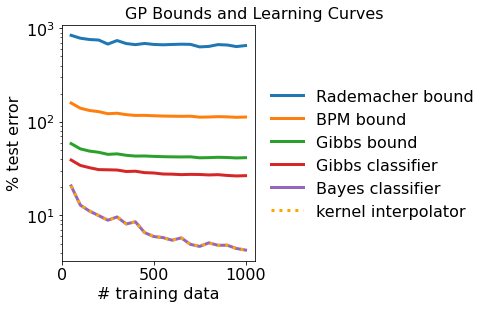

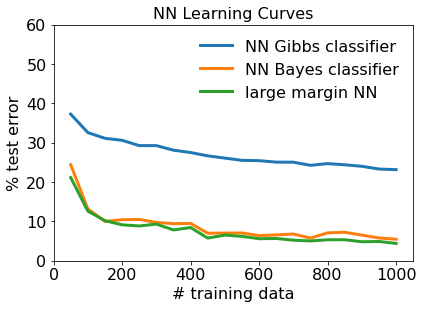

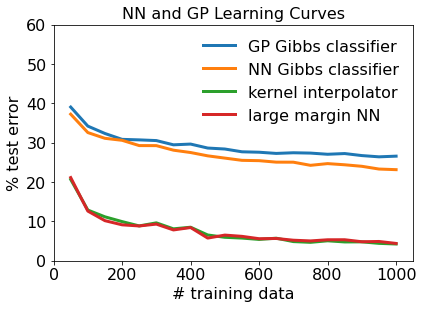

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bpm_bound_list = [item * math.e for item in gp_gibbs_bound_list]

plt.figure(figsize=(7, 4.4))
plt.plot(num_train_examples_list, rademacher_bound_list, label="Rademacher bound")
plt.plot(num_train_examples_list, bpm_bound_list, label="BPM bound")
plt.plot(num_train_examples_list, gp_gibbs_bound_list, label="Gibbs bound")
plt.plot(num_train_examples_list, gp_gibbs_list, label="Gibbs classifier")
plt.plot(num_train_examples_list, gp_bayes_list, label="Bayes classifier")
plt.plot(num_train_examples_list, kernel_list, label="kernel interpolator", linestyle='dotted', color='orange')
plt.xlabel("# training data")
plt.ylabel("% test error")
# plt.ylim(0,60)
plt.xlim(0,1050)
plt.yscale('log')
plt.legend(loc=(1.05,0.15))
plt.title("GP Bounds and Learning Curves", x=1.0)
plt.tight_layout()
plt.savefig('gp.pdf')
plt.show()

plt.figure(figsize=(6, 4.4))
plt.plot(num_train_examples_list, nn_gibbs_list, label="NN Gibbs classifier", linestyle='-')
plt.plot(num_train_examples_list, nn_bayes_list, label="NN Bayes classifier", linestyle='-')
plt.plot(num_train_examples_list, large_margin_nn_list, label="large margin NN", linestyle='-')
plt.xlabel("# training data")
plt.ylabel("% test error")
plt.ylim(0,60)
plt.xlim(0,1050)
plt.legend()
plt.title("NN Learning Curves")
plt.tight_layout()
plt.savefig('nn.pdf')
plt.show()

plt.figure(figsize=(6, 4.4))
plt.plot(num_train_examples_list, gp_gibbs_list, label="GP Gibbs classifier")
plt.plot(num_train_examples_list, nn_gibbs_list, label="NN Gibbs classifier", linestyle='-')
plt.plot(num_train_examples_list, kernel_list, label="kernel interpolator", linestyle='-')
plt.plot(num_train_examples_list, large_margin_nn_list, label="large margin NN", linestyle='-')
plt.xlabel("# training data")
plt.ylabel("% test error")
plt.ylim(0,60)
plt.xlim(0,1050)
plt.legend()
plt.title("NN and GP Learning Curves")
plt.tight_layout()
plt.savefig('nn-gp.pdf')
plt.show()

files.download('gp.pdf')
files.download('nn.pdf')
files.download('nn-gp.pdf')